# Sobol indices

In [1]:
import openturns as ot
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 

%matplotlib inline
%load_ext autoreload
%autoreload 2

## Gaussian Framework

In [109]:
from shapley.tests import Ishigami
model = Ishigami()
dim = model.dim
model.copula = ot.NormalCopula(dim)

theta = [-0.8, 0.6, -0.4]
#theta = [0.]*dim
model.copula_parameters = theta

### Monte-Carlo estimation using true model

In [110]:
from shapley import SobolIndices

sobol = SobolIndices(model.input_distribution)

In [111]:
%%time
ot.RandomGenerator.SetSeed(0)
np.random.seed(0)

n_sample = 10000
sobol.build_uncorr_sample(model=model, n_sample=n_sample)
budget = 4*n_sample*dim
print('Necessary budget = %d' % (budget))

Necessary budget = 120000
Wall time: 816 ms


In [112]:
%%time
ot.RandomGenerator.SetSeed(0)
np.random.seed(0)
sobol_results = {}

n_boot = 300
estimator = 'sobolmara'

for i, indice_type in enumerate(['full', 'ind']):    
    results = sobol.compute_indices(n_boot=n_boot, estimator=estimator, indice_type=indice_type)
    sobol_results[indice_type] = results

Wall time: 854 ms


In [113]:
X = np.asarray(model.get_input_sample(1000, 'monte-carlo'))
y = model(X)

In [135]:
%%time
from skgarden import RandomForestQuantileRegressor
from shapley.forest import compute_perm_indices, compute_shap_indices
from sklearn.ensemble import RandomForestRegressor
n_tree = 100
rfq = RandomForestRegressor(n_estimators=n_tree, n_jobs=7)
rfq.fit(X, y)

Wall time: 172 ms


In [136]:
%%time
results_permutation = {}
for i, indice_type in enumerate(['full', 'ind']):
    results_permutation[indice_type] = compute_perm_indices(rfq, X, y, model.input_distribution, indice_type=indice_type)
    results_permutation[indice_type].true_first_indices = model.first_sobol_indices
    results_permutation[indice_type].true_total_indices = model.total_sobol_indices

Wall time: 5.64 s


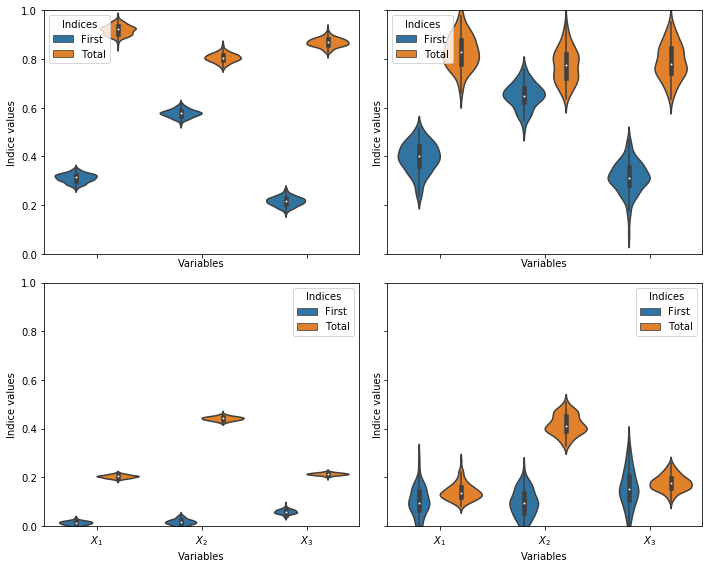

In [137]:
from shapley.plots import plot_sensitivity_results
ylim = [0., 1.]

fig, axes = plt.subplots(2, 2, figsize=(10, 8), sharex=True, sharey=True)
for i, indice_type in enumerate(['full', 'ind']):
    ax = axes[i, 0]
    plot_sensitivity_results(sobol_results[indice_type], ax=ax)
    ax = axes[i, 1]
    plot_sensitivity_results(results_permutation[indice_type], ax=ax)
    ax.set_ylim(ylim)
fig.tight_layout()

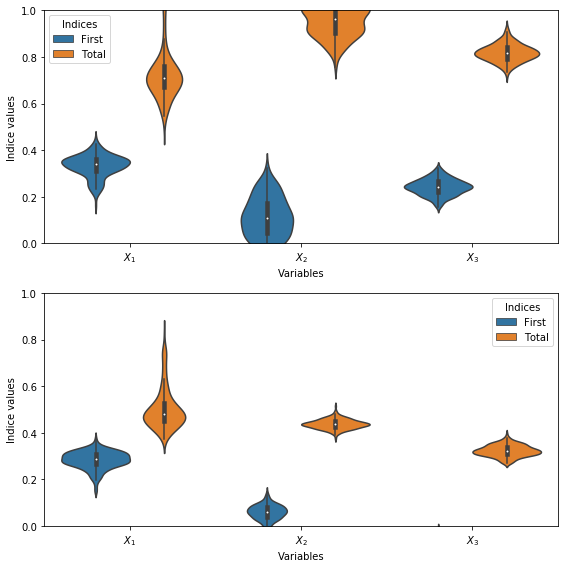

In [17]:
fig, axes = plt.subplots(2, 1, figsize=(8, 8))
for i, indice_type in enumerate(['full', 'ind']):
    ax = axes[i]
    plot_sensitivity_results(results=results_permutation[indice_type], ax=ax)
    ax.set_ylim(ylim)

fig.tight_layout()

### Monte-Carlo estimation using a Kriging model

In [ ]:
from shapley.kriging import KrigingModel
ot.RandomGenerator.SetSeed(0)
np.random.seed(0)

model_budget = 100
sampling = 'lhs'
library = 'OT'
kernel = 'matern'
basis = 'linear'

model_gp = KrigingModel(model=model, input_distribution=model.input_distribution)
model_gp.generate_sample(n_sample=model_budget, sampling=sampling, sampling_type='uniform')
model_gp.build(library=library, kernel=kernel, basis_type=basis)

In [20]:
# The score of the meta_model
q2_score_cv_gp = model_gp.compute_score_q2_cv(n_sample=10000, sampling_type='uniform')
print('Q2-score by cross-validation:', q2_score_cv_gp)

Q2-score by cross-validation: 0.827304035315


In [13]:
%%time
ot.RandomGenerator.SetSeed(0)
np.random.seed(0)

n_realization = 200
sobol.build_uncorr_sample(model=model_gp, n_sample=n_sample, n_realization=n_realization)

Wall time: 2.16 s


In [14]:
%%time
ot.RandomGenerator.SetSeed(0)
np.random.seed(0)

sobol_gp_results = {}
for i, indice_type in enumerate(['full', 'ind']):    
    results = sobol.compute_indices(n_boot=n_boot, estimator=estimator, indice_type=indice_type)
    sobol_gp_results[indice_type] = results

Wall time: 5.45 s


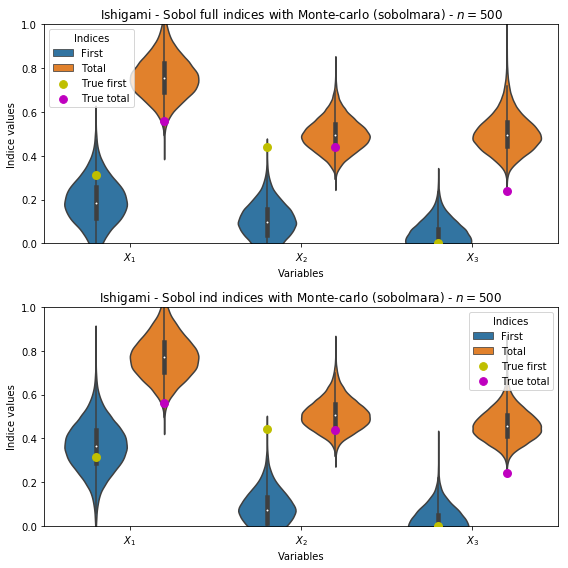

In [15]:
fig, axes = plt.subplots(2, 1, figsize=(8, 8))
for i, indice_type in enumerate(['full', 'ind']):
    ax = axes[i]
    plot_sensitivity_results(sobol_gp_results[indice_type], ax=ax)
    ax.set_title("%s - Sobol %s indices with Monte-carlo (%s) - $n=%d$" % (model.name, indice_type, estimator, n_sample))
    ax.set_ylim(ylim)
fig.tight_layout()

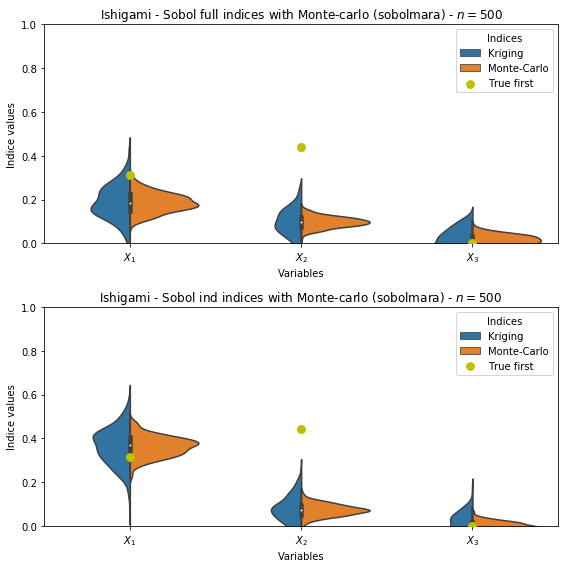

In [16]:
fig, axes = plt.subplots(2, 1, figsize=(8, 8))
for i, indice_type in enumerate(['full', 'ind']):
    ax = axes[i]
    plot_sensitivity_results(sobol_gp_results[indice_type], ax=ax, indice='first')
    ax.set_title("%s - Sobol %s indices with Monte-carlo (%s) - $n=%d$" % (model.name, indice_type, estimator, n_sample))
    ax.set_ylim(ylim)
fig.tight_layout()

### Monte-Carlo estimation using a Random Forest model

In [13]:
from shapley.forest import RandomForestModel
ot.RandomGenerator.SetSeed(0)
np.random.seed(0)

model_rf = RandomForestModel(model=model, input_distribution=model.input_distribution)
model_rf.generate_sample(n_sample=model_budget, sampling=sampling)
model_rf.build(n_realization)

In [14]:
# The score of the meta_model
q2_score_cv_rf = model_rf.compute_score_q2_cv(n_sample=10000, sampling_type='uniform')
print('Q2-score by cross-validation:', q2_score_cv_rf)

Q2-score by cross-validation: 0.873613570531


In [15]:
%%time
ot.RandomGenerator.SetSeed(0)
np.random.seed(0)
sobol.build_uncorr_sample(model_rf, n_sample=n_sample, n_realization=n_realization)

CPU times: user 380 ms, sys: 16 ms, total: 396 ms
Wall time: 383 ms


In [16]:
%%time
ot.RandomGenerator.SetSeed(0)
np.random.seed(0)

sobol_rf_results = {}
for i, indice_type in enumerate(['full', 'ind']):    
    results = sobol.compute_indices(n_boot=n_boot, estimator=estimator, indice_type=indice_type)
    sobol_rf_results[indice_type] = results

CPU times: user 7.71 s, sys: 7.87 s, total: 15.6 s
Wall time: 15.7 s


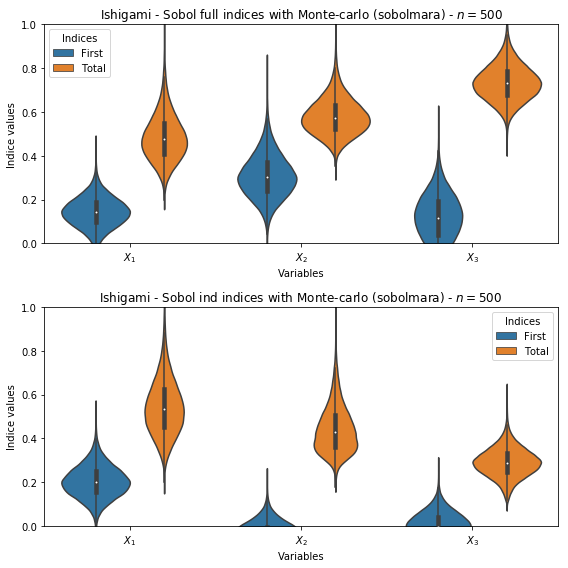

In [17]:
fig, axes = plt.subplots(2, 1, figsize=(8, 8))
for i, indice_type in enumerate(['full', 'ind']):
    ax = axes[i]
    plot_sensitivity_results(sobol_rf_results[indice_type], ax=ax)
    ax.set_title("%s - Sobol %s indices with Monte-carlo (%s) - $n=%d$" % (model.name, indice_type, estimator, n_sample))
    ax.set_ylim(ylim)
fig.tight_layout()

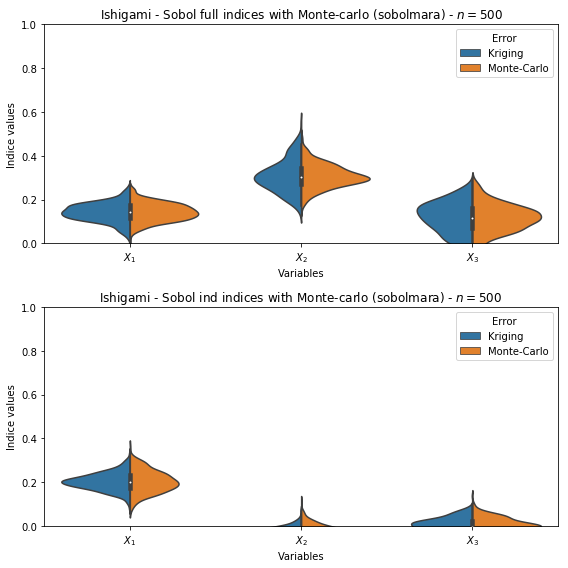

In [18]:
fig, axes = plt.subplots(2, 1, figsize=(8, 8))
for i, indice_type in enumerate(['full', 'ind']):
    ax = axes[i]
    plot_sensitivity_results(sobol_rf_results[indice_type], ax=ax, indice='first')
    ax.set_title("%s - Sobol %s indices with Monte-carlo (%s) - $n=%d$" % (model.name, indice_type, estimator, n_sample))
    ax.set_ylim(ylim)
fig.tight_layout()